# EEG Sample Processing (Muse JSON dumps)

Mirrors the app's processing pipeline for `samples_*.json` files. Loads from `raw_data/`, applies notch + Welch PSD, computes band powers, and renders visuals akin to the app (trace, PSD with band shading, spectrogram, band power bars).


### Diagnostics
- Files loaded, channels per file
- Sample counts per channel
- PSD window count and duration coverage

In [1]:
from pathlib import Path
from posixpath import expanduser
import json
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
DEFAULT_FS = 256  # Muse sampling rate
FS = DEFAULT_FS
NPERSEG = 1024  # ~4s windows at 256 Hz
NOVERLAP = NPERSEG // 2
BANDS = [
    {'key': 'delta', 'label': 'Delta', 'min': 0.5, 'max': 4},
    {'key': 'theta', 'label': 'Theta', 'min': 4, 'max': 8},
    {'key': 'alpha', 'label': 'Alpha', 'min': 8, 'max': 12},
    {'key': 'beta', 'label': 'Beta', 'min': 12, 'max': 30},
    {'key': 'gamma', 'label': 'Gamma', 'min': 30, 'max': 50},
]
# Prefer bundled raw_data if present, otherwise fall back to Downloads
RAW_DIR_CANDIDATES = [Path('notebooks/raw_data'), Path('raw_data'), Path(expanduser('~/Downloads/'))]
for candidate in RAW_DIR_CANDIDATES:
    if candidate.exists() and any(candidate.glob('samples_*.json')):
        RAW_DIR = candidate
        break
else:
    RAW_DIR = RAW_DIR_CANDIDATES[0]


In [2]:
import sys
from pathlib import Path

# Import reusable EEG processing helpers from notebooks/
_utils_dir = Path('notebooks')
if (_utils_dir / 'eeg_processing_utils.py').exists():
    sys.path.insert(0, str(_utils_dir.resolve()))

import eeg_processing_utils as eeg

# Keep module defaults aligned with notebook settings
eeg.DEFAULT_FS = DEFAULT_FS
eeg.NPERSEG = NPERSEG
eeg.NOVERLAP = NOVERLAP
eeg.BANDS = BANDS

# Re-export commonly used helpers
load_sample_exports = eeg.load_sample_exports
build_export_diagnostics = eeg.build_export_diagnostics
print_export_summary = eeg.print_export_summary
get_channel_labels = eeg.get_channel_labels
plot_raw_traces_per_label = eeg.plot_raw_traces_per_label
plot_spectrograms_per_label = eeg.plot_spectrograms_per_label
plot_band_power_diagrams = eeg.plot_band_power_diagrams


In [3]:

exports = load_sample_exports(RAW_DIR)
diag_df = build_export_diagnostics(exports)
print_export_summary(diag_df, RAW_DIR)


=== Sample Export Summary ===
RAW_DIR: raw_data
Files: 38
Total channels: 152
Channel labels: ['AF7', 'AF8', 'TP10', 'TP9']
CapturedAt range: 2026-01-21T08:46:58.159000+00:00 → 2026-01-21T09:23:58.143000+00:00
CaptureEndedAt range: 2026-01-21T08:47:58.156000+00:00 → 2026-01-21T09:24:58.140000+00:00
Sampling rates (Hz): [256.0]
Samples/channel (min/median/max): 15360 / 15360 / 15360
Duration/channel seconds (min/median/max): 60.00 / 60.00 / 60.00
Timestamps present (per-sample): 152/152 channels


### Raw EEG Traces (Per Electrode)

Plots the most recent window for each channel label found in the exports.


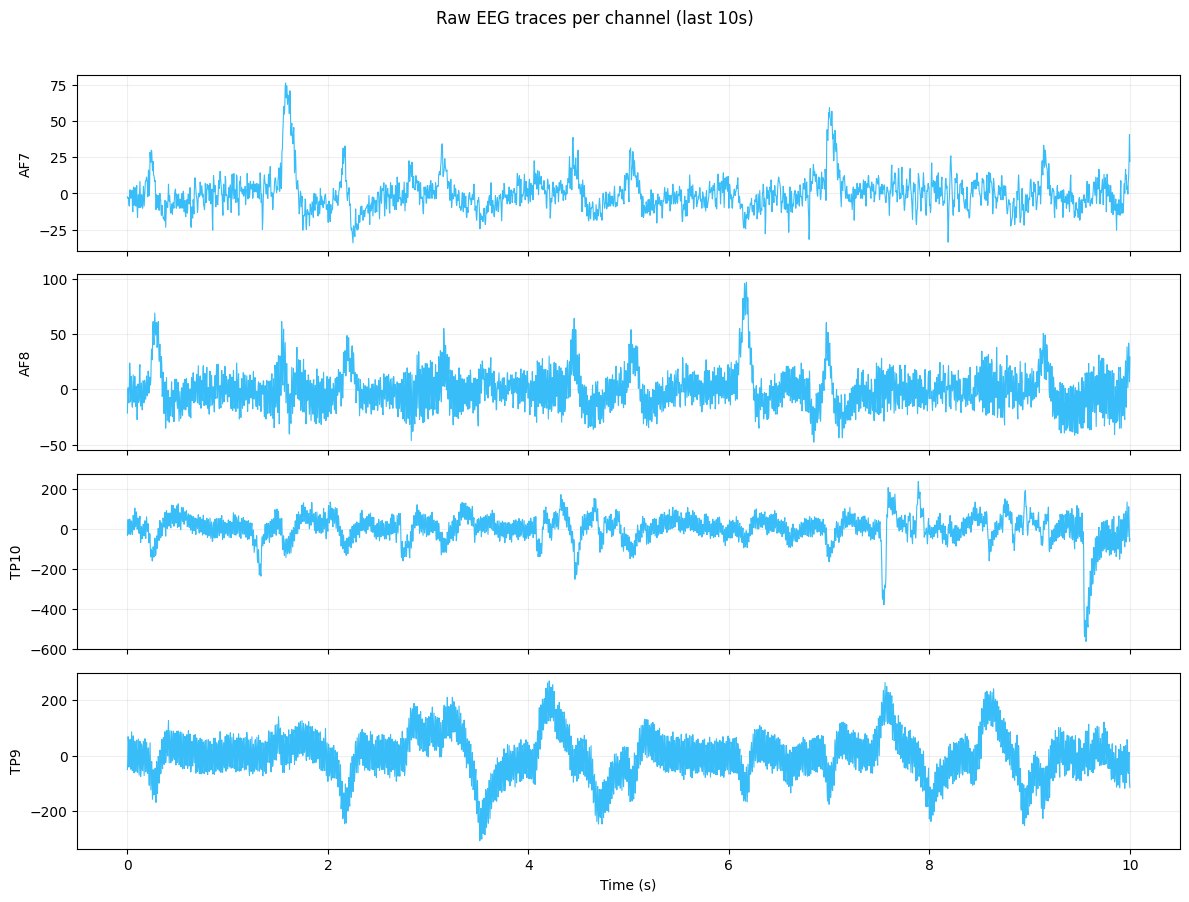

In [4]:
# Raw EEG traces per electrode channel
WINDOW_SEC = 10
MAX_POINTS = 3000
plot_raw_traces_per_label(exports, diag_df=diag_df, window_sec=WINDOW_SEC, max_points=MAX_POINTS)


### Spectrograms (Per Electrode)

Computes a spectrogram for each channel label and renders them as stacked time–frequency heatmaps.


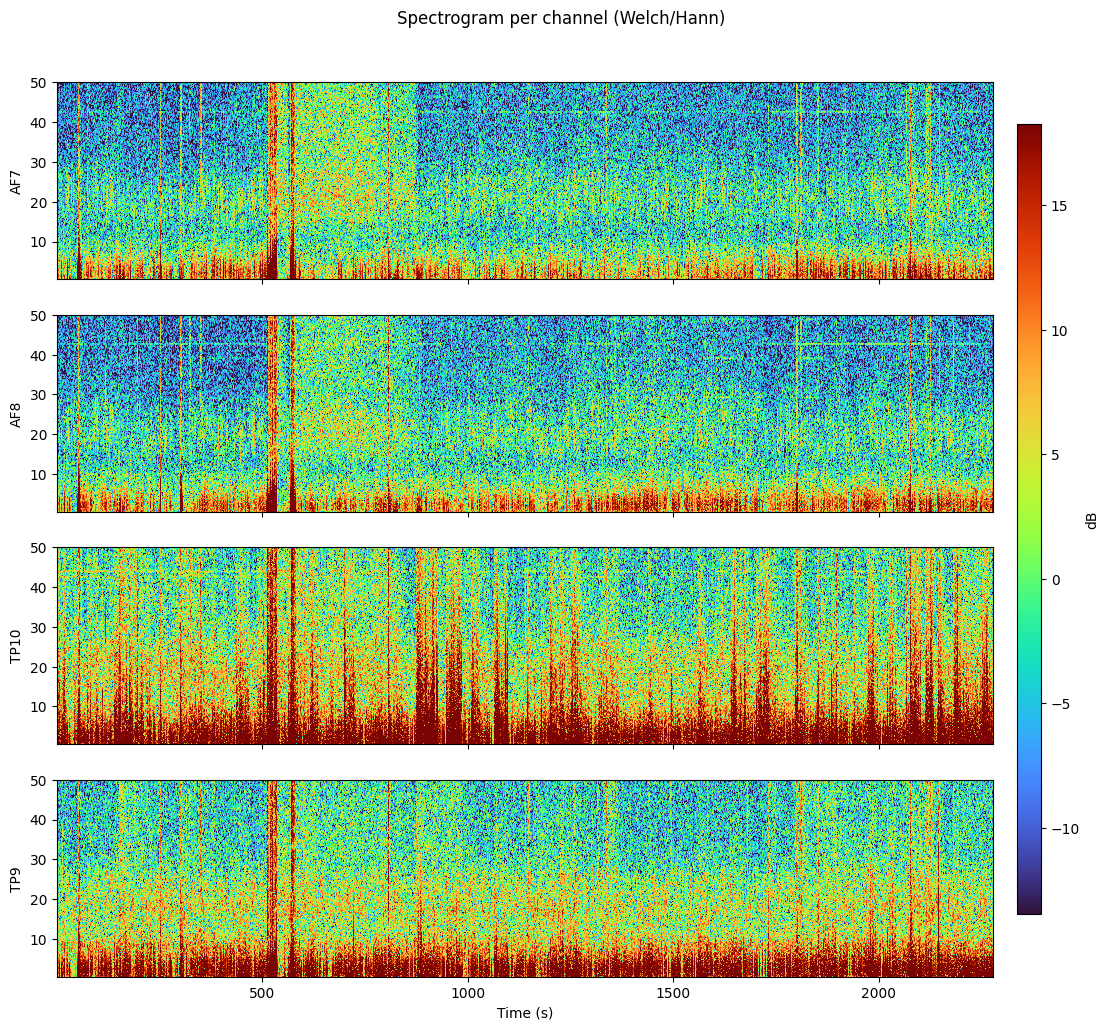

In [5]:
# Spectrograms per electrode channel
MAX_SPECTROGRAM_SEC = None  # set to e.g. 300 to cap compute time
plot_spectrograms_per_label(exports, diag_df=diag_df, max_spectrogram_sec=MAX_SPECTROGRAM_SEC, max_freq_hz=50)


### Band Power Diagrams

Creates band power line charts for each electrode, TP channels combined, AF channels combined, and all channels combined.


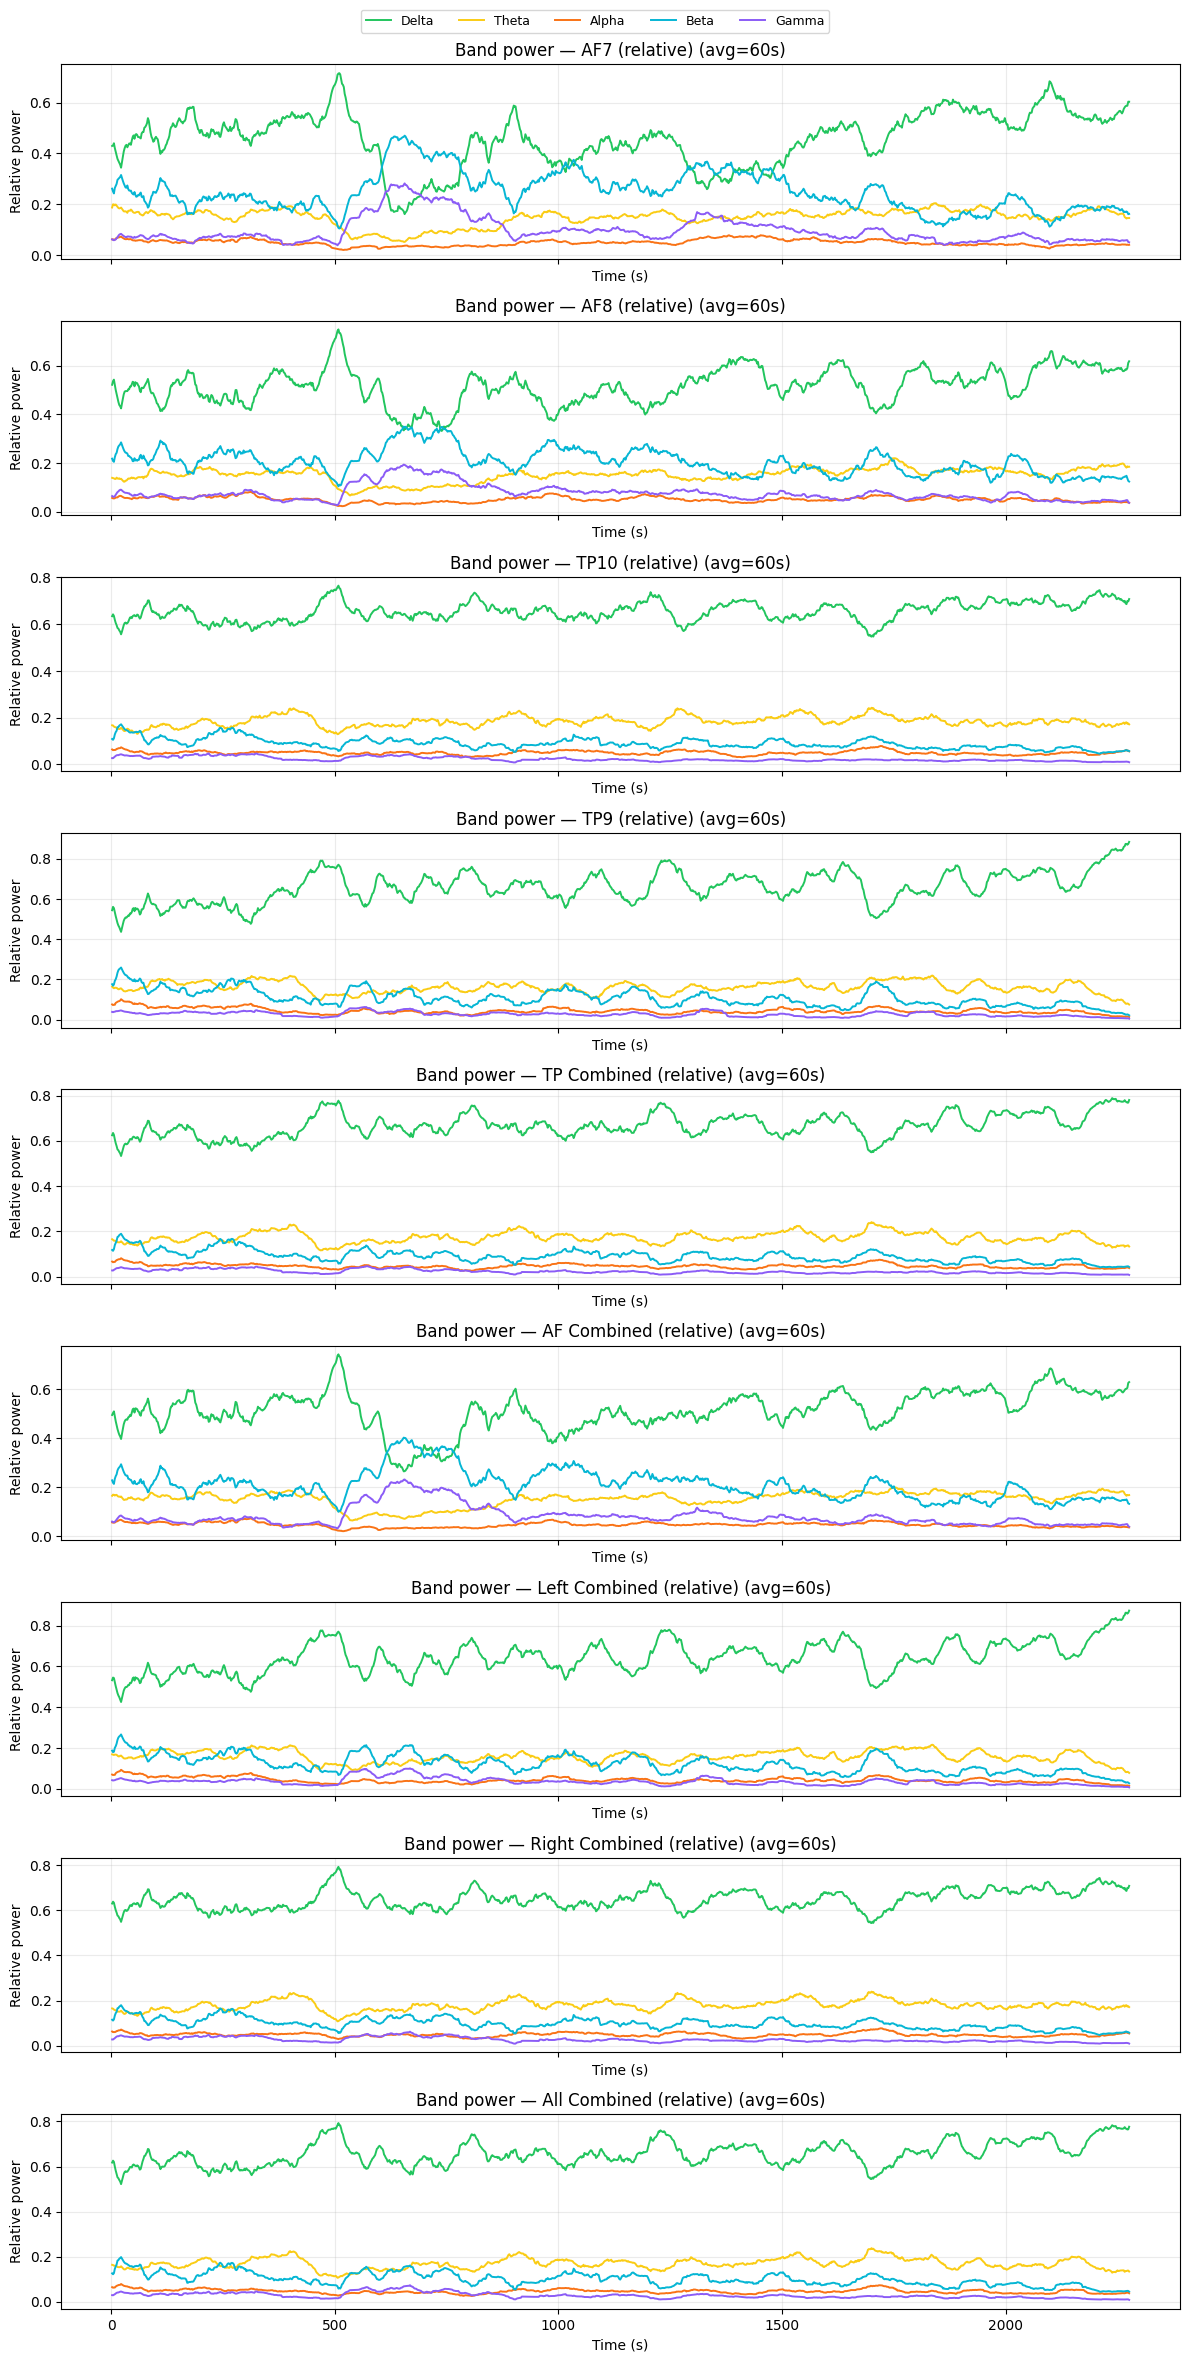

In [13]:
# Band power diagrams: per channel + combined groups
BAND_POWER_AVG_SEC = 60
PLOT_RELATIVE = True

_ = plot_band_power_diagrams(
    exports,
    diag_df,
    avg_sec=BAND_POWER_AVG_SEC,
    relative=PLOT_RELATIVE,
)
